# Лабораторная работа 1
* Напишите код, который позволяет найти всех сотрудников, у которых 2 и более должностей.
* Какое количество должностей у сотрудника максимальное?
* Напишите код, который считает количество сотрудников с ученой степенью.
* Какие бывают ученые степени?
* Постройте график: количество публикаций - количество сотрудников.
* Есть ли зависимость между наличием ученой степени и количеством публикаций?

# Импорт библиотек

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [78]:
from bs4 import BeautifulSoup as bs
from bs4 import Tag, NavigableString
import requests

# Обработка данных

In [166]:
data = []
prefix = 'https://itmo.ru/'

for page_number in range(192, 224):
    url = f'https://itmo.ru/ru/personlist/{page_number}/letter_{page_number}.htm'
    page = requests.get(url)
    soup = bs(page.text, "html.parser")
    data += list(map(lambda element: {
                        'URL': prefix + element['href'],
                        'name': element.find('h4', {'class': 'name'}).text
    }, soup.find_all(attrs={'class' : 'contact-pad -person-list'})))
print(f'Найдено {len(data)} сотрудников')

In [167]:
df = pd.DataFrame({
    'URL': [element['URL'] for element in data],
    'name': [element['name'] for element in data]
})

In [184]:
def get_soup(url):
    page = requests.get(url)
    soup = bs(page.text, "html.parser")
    return soup

In [185]:
def get_degree(soup):
    personal_information = soup.find('div', {'class': 'c-personCard-details'})
    for tag in personal_information.find_all({'dt'}):
        if 'ученая степень' in tag.text.lower():
            return tag.find_next_sibling('dd').text

In [186]:
def get_titles(soup):
    titles = []
    personal_information = soup.find('div', {'class': 'c-personCard-details'})
    for tag in personal_information.find_all({'dt'}):
        if 'должность' in tag.text.lower():
            current_title = ''
            for chunk in tag.find_next_sibling('dd').contents:
                if hasattr(chunk, 'name') and chunk.name == 'br':
                    titles.append(current_title.strip())
                    current_title = ''
                    continue
                if isinstance(chunk, NavigableString):
                    current_title += str(chunk)
                elif isinstance(chunk, Tag):
                    current_title += chunk.text
    return titles

In [165]:
def get_publications(soup):
    result = soup.find('a', {'aria-controls': 'publications'})
    return 0 if result is None else int(result.find('span', {'class': 'badge'}).text)

In [27]:
df['html'] = df['URL'].apply(lambda url: get_soup(url), 'html.parser')
df['degree'] = df['html'].apply(lambda soup: get_degree(soup))
df['with_degree'] = df['degree'].apply(lambda degree: degree is not None)
df['titles'] = df['html'].apply(lambda soup: get_titles(soup))
df['publications'] = df['html'].apply(lambda soup: get_publications(soup))

In [28]:
df

,URL,name,html,degree,titles,publications,with_degree
0,https://itmo.ru//ru/viewperson/1825/abdulova_m...,Абдулова Марина Айратовна,"[html, \n, [\n, [\n, <script>(function(w,d...",None,[Специалист отдела кадров],0,False
1,https://itmo.ru//ru/viewperson/1968/abramov_da...,Абрамов Даниил Александрович,"[html, \n, [\n, [\n, <script>(function(w,d...",None,[Кинооператор Управления студенческих медиа],0,False
2,https://itmo.ru//ru/viewperson/2019/abramova_m...,Абрамова Марина Игоревна,"[html, \n, [\n, [\n, <script>(function(w,d...",None,[Делопроизводитель медико-психолого-социальног...,0,False
3,https://itmo.ru//ru/viewperson/1291/avdeev_and...,Авдеев Андрей Анатольевич,"[html, \n, [\n, [\n, <script>(function(w,d...",кандидат экономических наук,[Помощник проректора по экономике и финансам р...,1,True
4,https://itmo.ru//ru/viewperson/1743/azanova_yu...,Азанова Юлия Аркадьевна,"[html, \n, [\n, [\n, <script>(function(w,d...",None,[Менеджер отдела организационно-нормативного о...,0,False
...,...,...,...,...,...,...,...
1030,https://itmo.ru//ru/viewperson/1886/yakovlev_i...,Яковлев Игорь Сергеевич,"[html, \n, [\n, [\n, <script>(function(w,d...",None,"[Тренер-преподаватель секций волейбола, баскет...",0,False
1031,https://itmo.ru//ru/viewperson/1201/yakovleva_...,Яковлева Дарья Владимировна,"[html, \n, [\n, [\n, <script>(function(w,d...",None,[Программист факультета информационных техноло...,6,False
1032,https://itmo.ru//ru/viewperson/1254/yakovleva_...,Яковлева Мария Владимировна,"[html, \n, [\n, [\n, <script>(function(w,d...",None,[Заместитель директора Центра имиджевых проектов],0,False
1033,https://itmo.ru//ru/viewperson/1965/yakovchenk...,Яковченко Наталья Владимировна,"[html, \n, [\n, [\n, <script>(function(w,d...",кандидат технических наук,[Доцент (квалификационная категория «Ординарны...,38,True


# Анализ данных

In [187]:
n = 2
print(f'Список всех сотрудников с {n} или более должностями:')
df[df.titles.str.len() >= n][['name']].reset_index(drop=True)

Список всех сотрудников с 2 или более должностями:


,name
0,Алейник Артем Сергеевич
1,Алексеев Александр Алексеевич
2,Алексеев Геннадий Валентинович
3,Алиев Тауфик Измайлович
4,Алоджанц Александр Павлович
...,...
422,Атращенко Александр Васильевич
423,Югансон Андрей Николаевич
424,Яковлев Игорь Сергеевич
425,Яковченко Наталья Владимировна


In [188]:
max_titles = df['titles'].str.len().max()
print(f'Максимальное количество должностей у сотрудника: {max_titles}')

Максимальное количество должностей у сотрудника: 5


In [189]:
employees = df[pd.notnull(df.degree)].shape[0]
print(f'Количество сотрудников с ученой степенью: {employees}')

Количество сотрудников с ученой степенью: 502


In [190]:
print('Список различных ученых должностей:')
pd.DataFrame(df['degree'].sort_values().str.capitalize().dropna().unique(), columns=['degree'])

Список различных ученых должностей:


,degree
0,"Phd, технические науки"
1,"Phd, физико-математические науки"
2,"Phd, философские науки"
3,Доктор технических наук
4,Доктор физико-математических наук
5,Доктор физико-математических наук
6,Доктор химических наук
7,Кандидат культурологии
8,Кандидат технических наук
9,Доктор медицинских наук


Text(0, 0.5, 'Количество сотрудников')

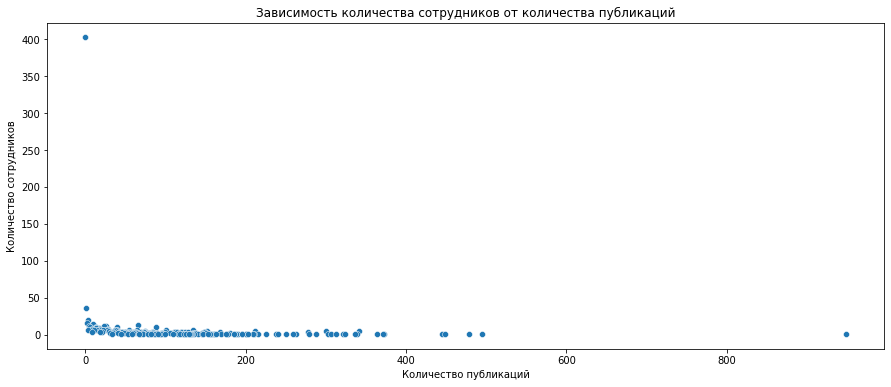

In [191]:
publications_df = pd.DataFrame(df.publications.value_counts()).reset_index().rename(columns={
    'publications': 'employees',
    'index': 'publications'
})

plt.figure(figsize=(15, 6))
sns.scatterplot(data=publications_df, x='publications', y='employees')
plt.title('Зависимость количества сотрудников от количества публикаций')
plt.xlabel('Количество публикаций')
plt.ylabel('Количество сотрудников')

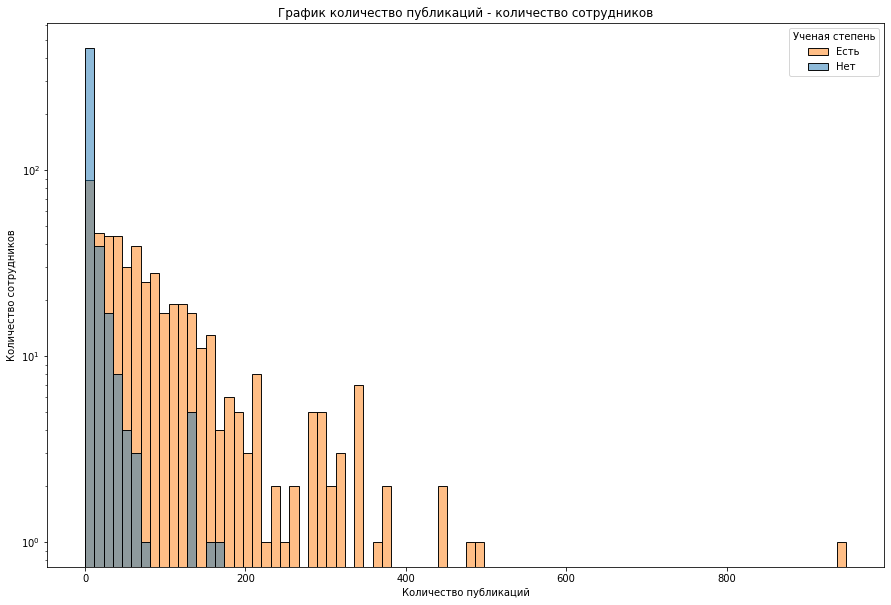

In [192]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df, x='publications', hue='with_degree')
plt.yscale('log')
plt.title('График количество публикаций - количество сотрудников')
plt.xlabel('Количество публикаций')
plt.ylabel('Количество сотрудников')
plt.legend(title='Ученая степень', labels=['Есть', 'Нет'])

Text(0, 0.5, 'Количество публикаций')

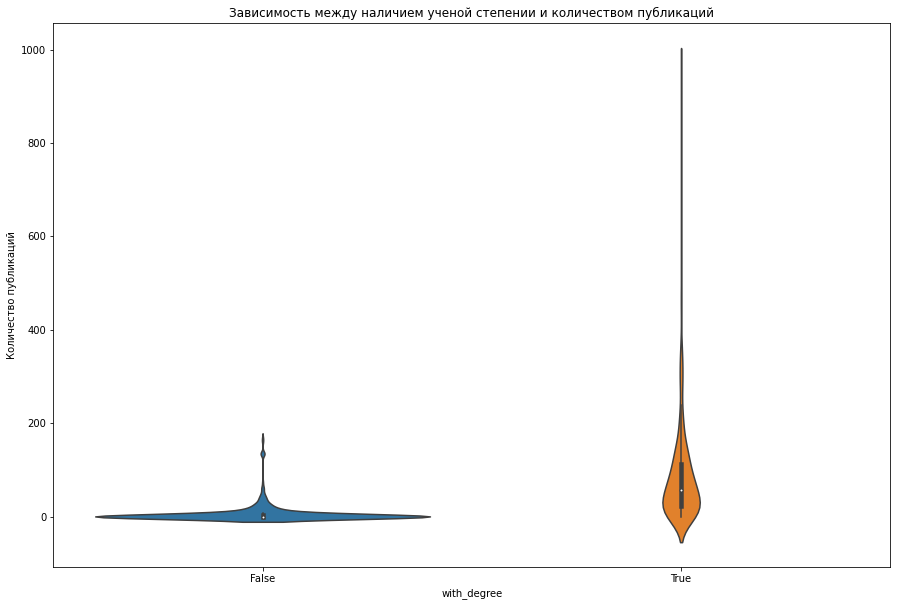

In [193]:
plt.figure(figsize=(15, 10))
sns.violinplot(data=df, y='publications', x='with_degree')
plt.title('Зависимость между наличием ученой степении и количеством публикаций')
plt.ylabel('Количество публикаций')

Из построенных распределений видно, что сотрудники с наличием ученой степени в подавляющем большинстве случаев имеют больше публикаций, чем сотрудники без них. В этом также можно убедиться, сравнив средние значения в обоих выборках:

In [194]:
df.groupby('with_degree')[['publications']].agg(['mean', 'std'])

publications           
                    mean        std
with_degree                        
False           6.178236  18.818288
True           82.894422  94.346216

Среднее число публикаций для людей с ученой степенью составляет 83, в то время как у сотрудников без ученой степени - всего лишь 6. Также по значениям стандартного отклонения видно, что для сотрудников со степенью разброс значений намного шире.